<a href="https://colab.research.google.com/github/LeandroMAcosta/clustering_nlp/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U spacy==3.1.2
!pip install -U umap
!pip install umap-learn
!python -m spacy download es_core_news_md

In [ ]:
import spacy
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster import cosine_distance, euclidean_distance
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import random

In [44]:
# Settings
ROOTCORPUS = "./corpus/"
file_name = "lavoztextodump.txt"
MAX_LINES = 1500000
NUMBER_OF_CLUSTERS = 100
SENTENCE_SIZE = 10
NUMBER_OF_ITERATIONS = 600
THRESHOLD_WORD = 50
THRESHOLD_CONTEXT = 20
THRESHOLD_VECTOR = 0.0001
CONTEXT_SIZE = 8
ignored_words = ["el", "él", "que", "de", "en"]

In [58]:
filename_path = ROOTCORPUS + file_name
text_file = open(filename_path, "r")
corpus = text_file.read()
text_file.close()
nlp = spacy.load("es_core_news_md")
nlp.max_length = MAX_LINES
doc = nlp(corpus[:MAX_LINES])

In [59]:
sents = [list(filter(lambda word: not word.is_stop, sent)) for sent in doc.sents if len(sent) > SENTENCE_SIZE]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha and word.lemma_ not in ignored_words:
            words.append(word)
            words_lemma.append(word.lemma_)
            
counts_lemma = Counter(words_lemma)

In [71]:
def build_features(words, counts_lemma):
    features = defaultdict(lambda:defaultdict(int))
    for word in words:
        lemma_str = word.lemma_
        if counts_lemma[lemma_str] < THRESHOLD_WORD or word.like_num:
            continue
        
        i = word.i
        context_left = doc[max(i - CONTEXT_SIZE, 0): i] 
        context_right = doc[i + 1 : min(len(doc), i+1+CONTEXT_SIZE)]
        context = list(context_left) + list(context_right)
        for c_word in context:       
            c_lemma = c_word.lemma_ 
            if c_word.is_alpha and counts_lemma[c_lemma] > THRESHOLD_CONTEXT: 
                if c_word.like_num: 
                    features[lemma_str]["POS__" + word.pos_ + "__" + c_lemma + "__NUM"] += 1
                else:
                    features[lemma_str]["POS__" + word.pos_ + "__" + c_lemma] += 1

    keys = list(features.keys())
    features_arr = list(features.values())
    return keys, features_arr


In [72]:
def vectorizer(features):
    v = DictVectorizer(sparse=False)
    vectors_matrix = v.fit_transform(features)
    return vectors_matrix

def normalize_matrix(vectors_matrix):
    normalized_matrix = vectors_matrix / vectors_matrix.max(axis=0)
    variances = np.square(normalized_matrix).mean(axis=0) - np.square(normalized_matrix.mean(axis=0))
    normalized_matrix = np.delete(normalized_matrix, np.where(variances < THRESHOLD_VECTOR), axis=1)
    return normalized_matrix

def dimension_reduction(vectors_matrix):
    umap = UMAP(n_components=2, random_state=400, n_neighbors=5, min_dist=0.01)
    vectors_matrix_2d = umap.fit_transform(vectors_matrix)
    return vectors_matrix_2d
 
def clustering(vectors):
    kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, max_iter=NUMBER_OF_ITERATIONS, random_state=100)
    kmeans.fit(vectors)
    v_labels = kmeans.predict(vectors)
    return v_labels

def clustering_2(k, vectors):
    clusterer = KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(vectors, True)
    return clusters

In [73]:
keys, features = build_features(words, counts_lemma)

[sostiene, a, pareja, amor, Clara, Crespo, y, Rodolfo, Martínez, imaginan, años, casados, y, hijas, mujeres, conocieron, Ateneo, Juventus, movimiento, juvenil, Capuchinos, aseguran, sorprendidos, llevan, juntos, logrado, entenderse, gusta, cariñosa, alegre, y, esté, pensando, y, madre, disgustaba, enojaba, quería, hablar, gusta, persona, emprendedora, alegre, optimista, y, servicial, gustaría, a, sutil, Pienso, personas, cambiando, a, edad, a, circunstancias, vivimos, y, rodea, Seguramente, casamos, y, seguiremos, descubriendo, conversar, y, ayudarse, a, cambiar, molestan, dolor, grande, ve, vida, y, problema, grande, ayudó, compartimos, fe, Dios, y, a, podes, darle, sentido, a, muerte, vivimos, separados, año, y, razones, Rody, Clara, asegura, sostiene, a, pareja, amor, proyectos, y, objetivos, común, ayudan, a, ilusiones, y, ganas, seguir, juntos, inútil, amor, tratar, crecer, aspectos, forma, permanente, matrimonio, a, plazo, refugio, inseguridades, rareza, triunfo, orgullo, feliz, 

In [74]:
vectors_matrix = vectorizer(features)
normalized_matrix = normalize_matrix(vectors_matrix)
vectors_matrix_2d = dimension_reduction(normalized_matrix)

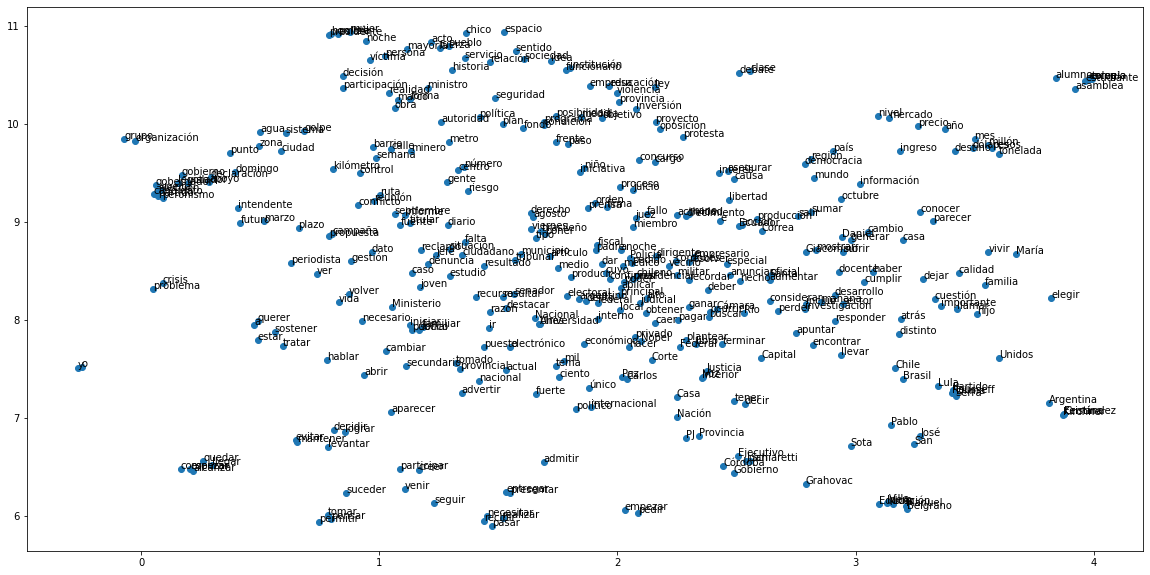

In [75]:
x_axis = [point[0] for point in vectors_matrix_2d]
y_axis = [point[1] for point in vectors_matrix_2d]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x_axis, y_axis)

for i, key in enumerate(keys):
    ax.annotate(key, (x_axis[i], y_axis[i]))

In [76]:
# kmeans, v_labels = clustering(vectors_matrix)
v_labels = clustering(vectors_matrix_2d)


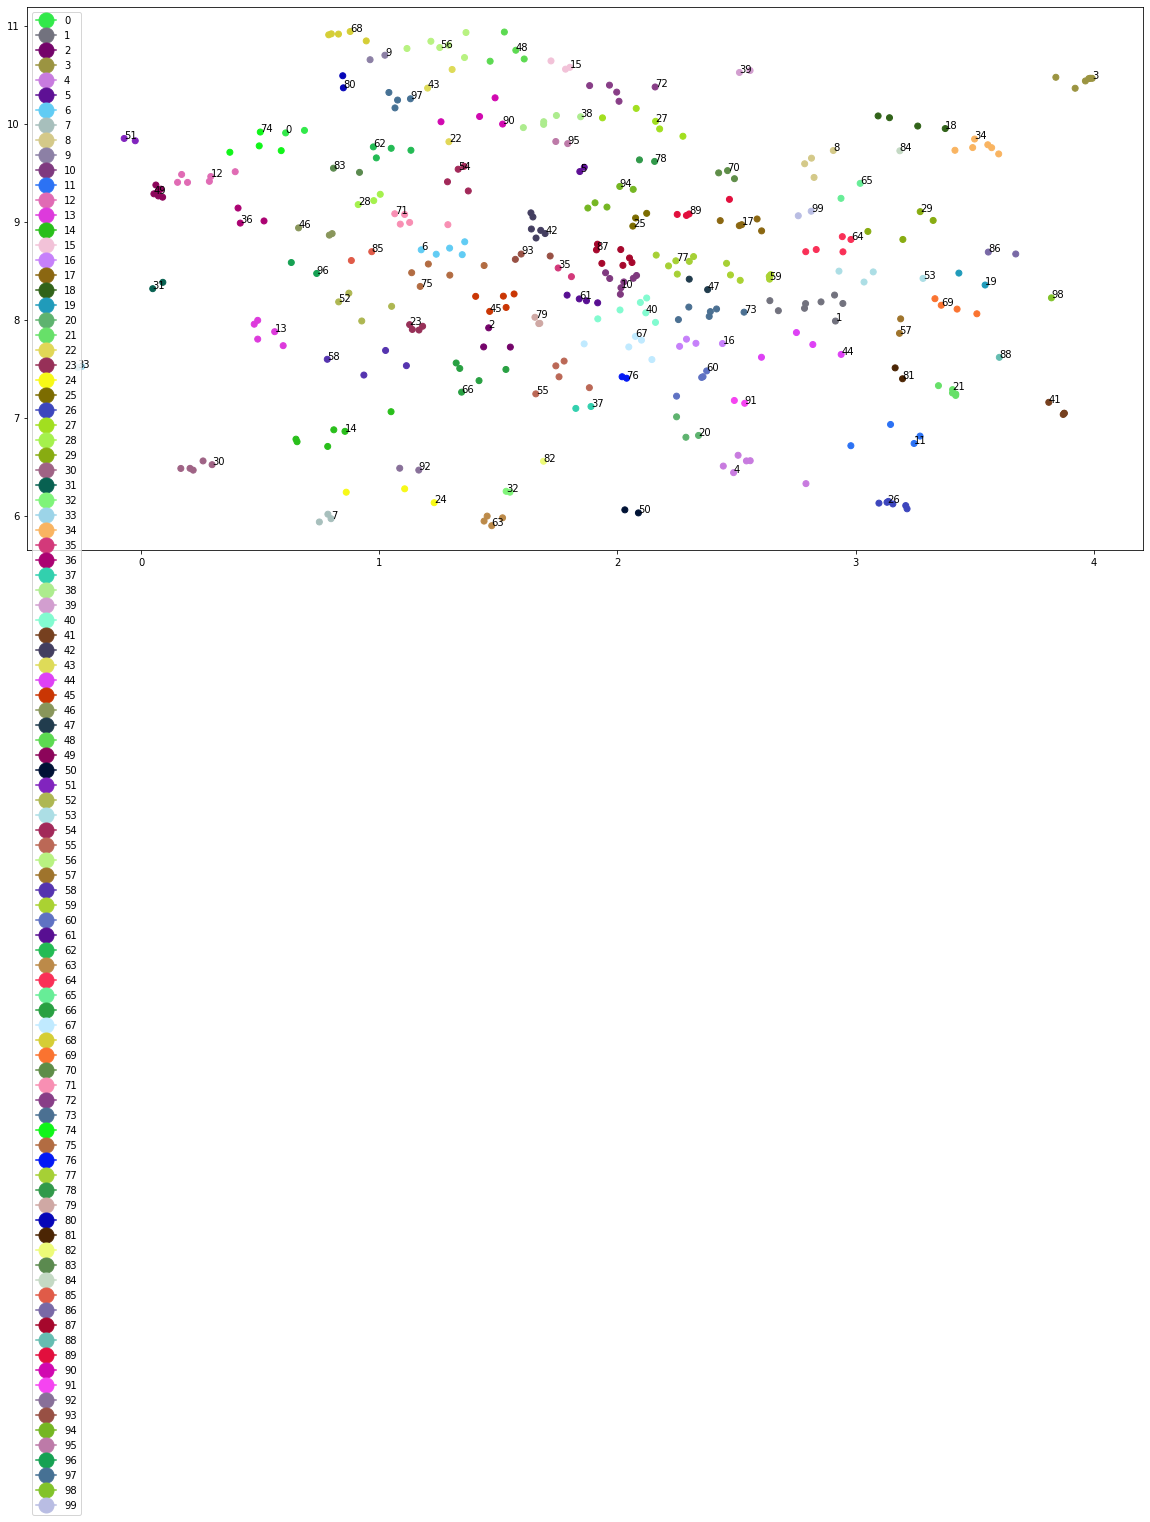

In [77]:
set_labels = set(v_labels)
colors = defaultdict(int)
for label in set_labels:
    colors[label] = "#" + "".join([random.choice('0123456789ABCDEF') for _ in range(6)])

x_axis = [point[0] for point in vectors_matrix_2d]
y_axis = [point[1] for point in vectors_matrix_2d]
colors_axis = [label for label in list(set_labels)]

fig, ax = plt.subplots(figsize=(20,10))
scatter = ax.scatter(x_axis, y_axis, label=v_labels, c=[colors[label] for label in v_labels])

legend_elements = [
    Line2D([0], [0], marker='o', color=color, label=label, markersize=15)
    for label, color in colors.items()]
ax.legend(handles=legend_elements)

clusters = defaultdict(list)
ploted_label = defaultdict(bool)
for i, label in enumerate(v_labels):
    clusters[label].append(keys[i])
    if not ploted_label[label]:
        ax.annotate(label, (x_axis[i], y_axis[i]))
        ploted_label[label] = True

plt.show()

In [78]:
for i, cluster in enumerate(clusters.values()):
    if "país" in cluster or "voto" in cluster or "Argentina" in cluster or "dólares" in cluster :
        print(i, cluster)

clusters[8]

48 ['mes', 'destino', 'tonelada', 'millón', 'dólares', 'pesos']
67 ['Argentina', 'Cristina', 'Fernández', 'Kirchner']
70 ['declaración', 'legislador', 'voto', 'gobierno', 'apoyo', 'domingo']
76 ['país', 'mundo', 'democracia', 'región']


['país', 'mundo', 'democracia', 'región']